In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import requests
import seaborn as sns   
import matplotlib.patches as patches

df = pd.read_csv('sales_dataset.csv')
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [308]:
# Zaman sütununu date formatına çevir ve index olarak ayarla
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [309]:
# Tekrar eden sütunları kontrol etme ve kaldırma
df = df.loc[:, ~df.columns.duplicated()]

# Veri setinin şekli ve bilgi
print(df.shape)
print(df.info())

(896, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 896 entries, 2024-03-01 10:15:50.520000 to 2024-06-30 21:04:09.746000
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         896 non-null    object 
 1   cash_type    896 non-null    object 
 2   card         807 non-null    object 
 3   money        896 non-null    float64
 4   coffee_name  896 non-null    object 
dtypes: float64(1), object(4)
memory usage: 42.0+ KB
None


In [310]:
# Gerekli sütunları seç
df = df['coffee_name']


In [311]:
# Kategorik değişkenleri (kahve türleri) one-hot encode yapalim
df = pd.get_dummies(df, columns=['coffee_name'])

In [312]:
# Günlük toplam satışları hesapla
data_all_days = df.resample('D').sum()


In [313]:
# Veriyi normalleştir
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_all_days)

In [314]:
# Eğitim ve test veri setlerini ayır
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [315]:
def timeseries_dataset(data, time_step=1):
    x, y = [], []
    for i in range(len(data) - time_step):
        x.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 1])  # 0 yerine tahmin etmek istediğiniz sütunu seçin
    return np.array(x), np.array(y)

In [316]:
# Zaman adımı
time_step = 10
x_train, y_train = timeseries_dataset(train_data, time_step)
x_test, y_test = timeseries_dataset(test_data, time_step)

print(x_train.shape, y_train.shape)  # Veri boyut kontrol
print(x_test.shape, y_test.shape)  # Veri boyut kontrol

(87, 10, 8) (87,)
(15, 10, 8) (15,)


In [317]:
# NumPy dizilerini PyTorch tensörlerine dönüştürme
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Boyut uyumu için unsqueeze
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Boyut uyumu için unsqueeze

# TensorDataset oluşturma
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# DataLoader oluşturma
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [318]:
# LSTM modeli tanımlama
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_dim, 25)
        self.fc2 = nn.Linear(25, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        c0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        
        out, _ = self.lstm1(x, (h0, c0))
        out, _ = self.lstm2(out)
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [319]:
# Model parametreleri
input_dim = x_train.shape[2]
hidden_dim = 50
output_dim = 1  
num_layers = 1

m = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# Kayıp fonksiyonu ve optimizasyon algoritmasını belirleme
criterion = nn.MSELoss()
optimizer = optim.Adam(m.parameters(), lr=0.001)


Epoch 1/50, Train Loss: 0.19861609488725662, Validation Loss: 0.22463785111904144
Epoch 2/50, Train Loss: 0.17529377341270447, Validation Loss: 0.20121341943740845
Epoch 3/50, Train Loss: 0.16102111339569092, Validation Loss: 0.17884336411952972
Epoch 4/50, Train Loss: 0.15132328122854233, Validation Loss: 0.15925222635269165
Epoch 5/50, Train Loss: 0.1308378167450428, Validation Loss: 0.13564066588878632
Epoch 6/50, Train Loss: 0.09423132613301277, Validation Loss: 0.10860642790794373
Epoch 7/50, Train Loss: 0.08191727474331856, Validation Loss: 0.08047940582036972
Epoch 8/50, Train Loss: 0.05908518470823765, Validation Loss: 0.05184400454163551
Epoch 9/50, Train Loss: 0.0463155098259449, Validation Loss: 0.0339590460062027
Epoch 10/50, Train Loss: 0.05733780562877655, Validation Loss: 0.034766893833875656
Epoch 11/50, Train Loss: 0.0711732804775238, Validation Loss: 0.03399896249175072
Epoch 12/50, Train Loss: 0.05811020918190479, Validation Loss: 0.033663228154182434
Epoch 13/50, Tr

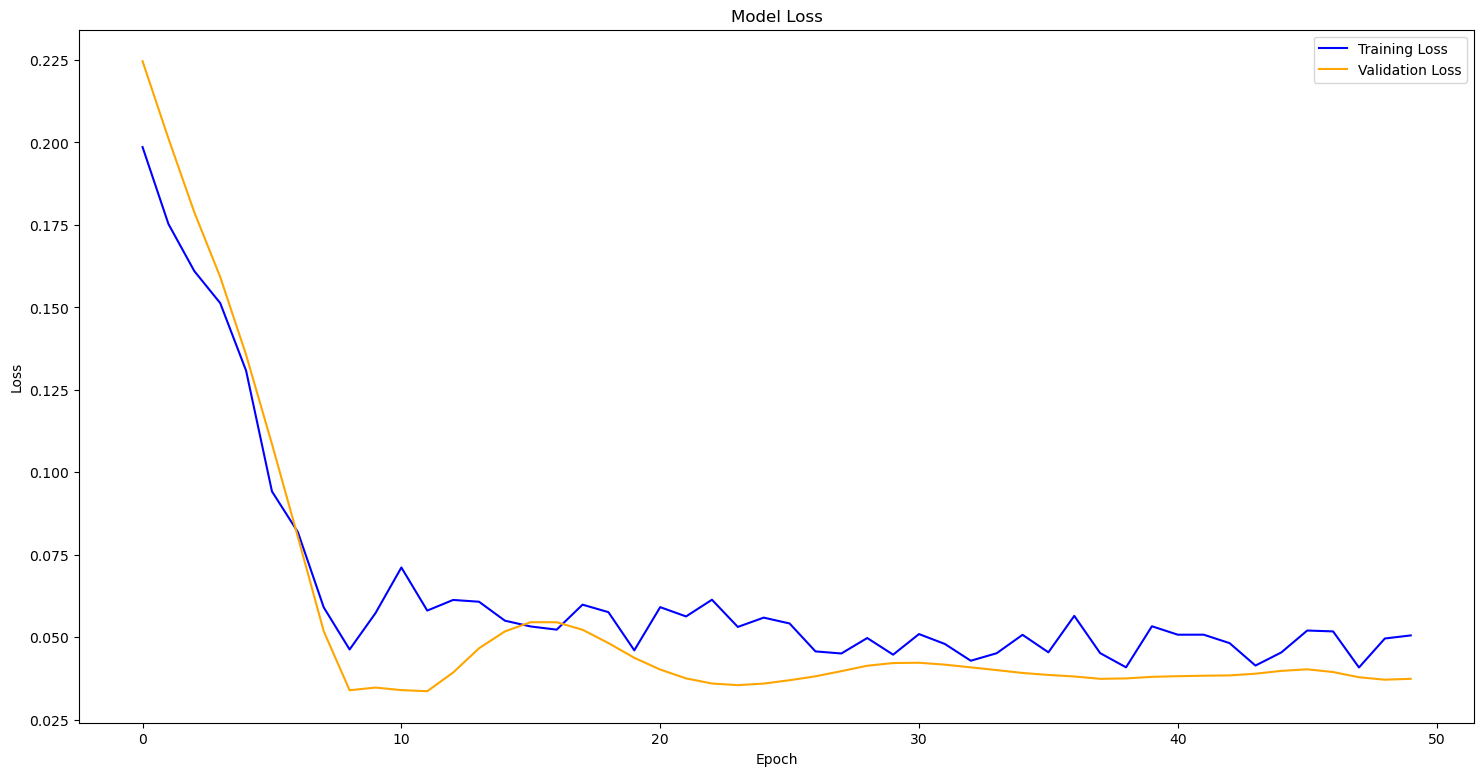

In [320]:
# Eğitim ve doğrulama kayıplarını saklamak için listeler oluştur
train_losses = []
val_losses = []

# Model eğitimi ve ağırlıkları kaydetme
num_epochs = 50
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    m.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = m(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    m.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            predictions = m(x_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

# Model ağırlıklarını kaydet
torch.save(m.state_dict(), best_model_path)

# Kayıpları çizme
plt.figure(figsize=(18, 9))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


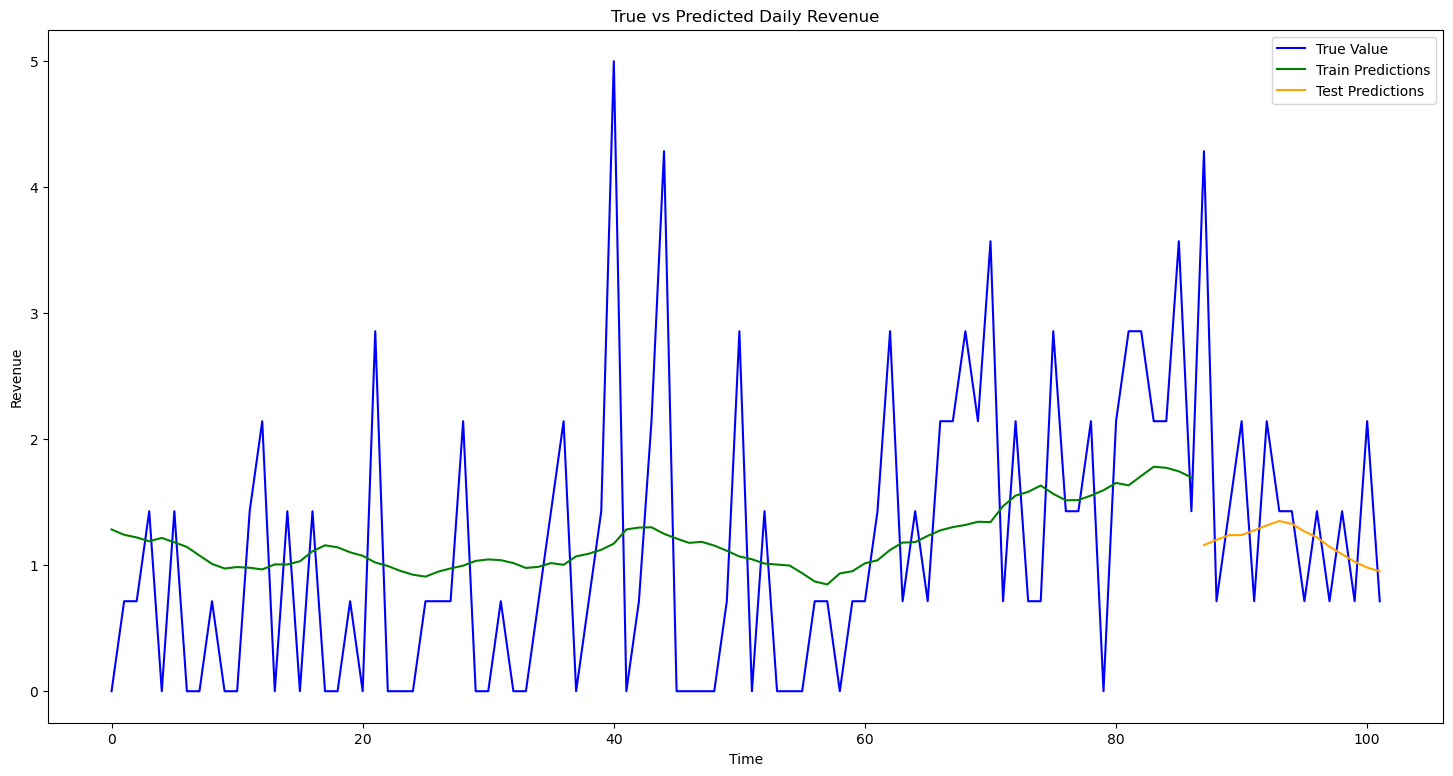

In [321]:
# Eğitim seti üzerinde tahminler yapma
m.eval()
with torch.no_grad():
    train_predictions = m(x_train).numpy()
    test_predictions = m(x_test).numpy()

# Tahminleri ve gerçek değerleri ters ölçekleme
train_predictions = scaler.inverse_transform(
    np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]
train_y = scaler.inverse_transform(
    np.concatenate((y_train.numpy(), np.zeros((y_train.numpy().shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]

test_predictions = scaler.inverse_transform(
    np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]
test_y = scaler.inverse_transform(
    np.concatenate((y_test.numpy(), np.zeros((y_test.numpy().shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]

# Eğitim ve test seti tahminlerini ve gerçek değerleri birleştirme
full_real = np.concatenate((train_y, test_y), axis=0)
full_predictions = np.concatenate((train_predictions, test_predictions), axis=0)

# Grafik çizme
plt.figure(figsize=(18, 9))
plt.plot(full_real, label='True Value', color='blue')
plt.plot(np.arange(len(train_predictions)), train_predictions, label='Train Predictions', color='green')
plt.plot(np.arange(len(train_predictions), len(train_predictions) + len(test_predictions)), test_predictions, label='Test Predictions', color='orange')
plt.title('True vs Predicted Daily Revenue')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [322]:
# Günlük toplam kahve satışlarını hesapla
daily_sales = data_all_days.sum(axis=1)
print(daily_sales.head())

# Günlük kahve türlerinin sayısını hesapla
daily_coffee_counts = data_all_days
print(daily_coffee_counts.head())


datetime
2024-03-01    11
2024-03-02     7
2024-03-03    10
2024-03-04     4
2024-03-05     9
Freq: D, dtype: int64
            Americano  Americano with Milk  Cappuccino  Cocoa  Cortado  \
datetime                                                                 
2024-03-01          1                    4           0      1        0   
2024-03-02          3                    3           0      0        0   
2024-03-03          1                    2           0      1        2   
2024-03-04          0                    1           0      0        0   
2024-03-05          0                    0           0      1        1   

            Espresso  Hot Chocolate  Latte  
datetime                                    
2024-03-01         0              3      2  
2024-03-02         0              0      1  
2024-03-03         0              2      2  
2024-03-04         1              0      2  
2024-03-05         0              4      3  


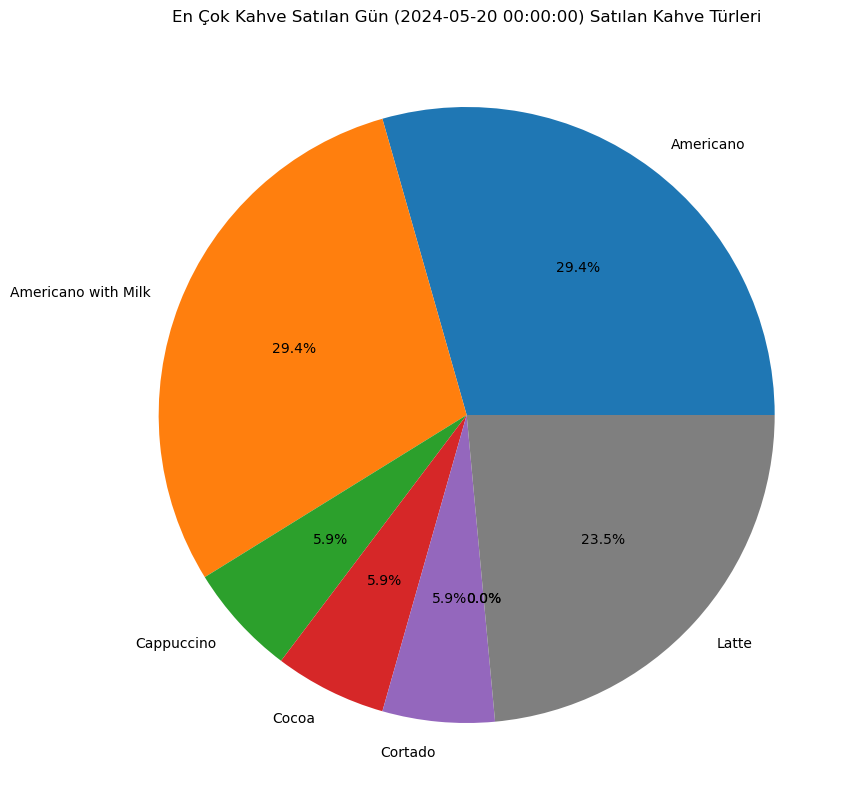

In [323]:
# En çok kahve satılan günü bul
most_sales_day = daily_sales.idxmax()
most_sales_day_counts = daily_coffee_counts.loc[most_sales_day]

# Pasta grafiği
most_sales_day_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), legend=False)
plt.title(f'En Çok Kahve Satılan Gün ({most_sales_day}) Satılan Kahve Türleri')
plt.ylabel('')
plt.show()


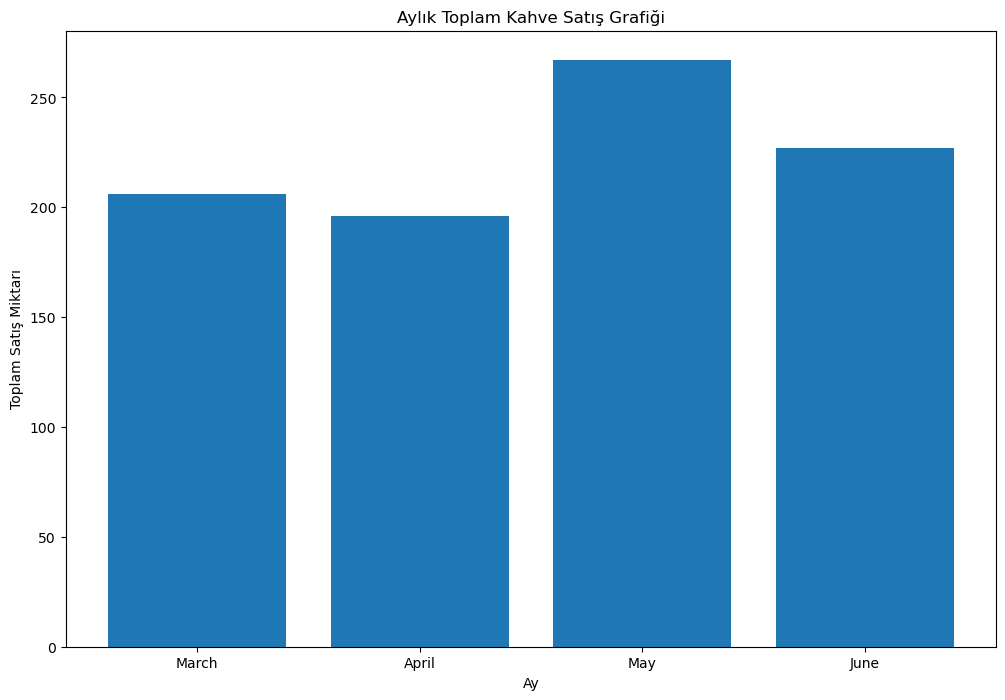

In [324]:
# Aylık toplam kahve satışlarını hesapla
monthly_sales = daily_sales.resample('ME').sum()

# Ay isimlerini almak için ay dizisi oluştur
month_names = monthly_sales.index.strftime('%B')

# Aylık toplam kahve satışlarını çiz
plt.figure(figsize=(12, 8))
plt.bar(month_names, monthly_sales)
plt.title('Aylık Toplam Kahve Satış Grafiği')
plt.xlabel('Ay')
plt.ylabel('Toplam Satış Miktarı')
plt.show()


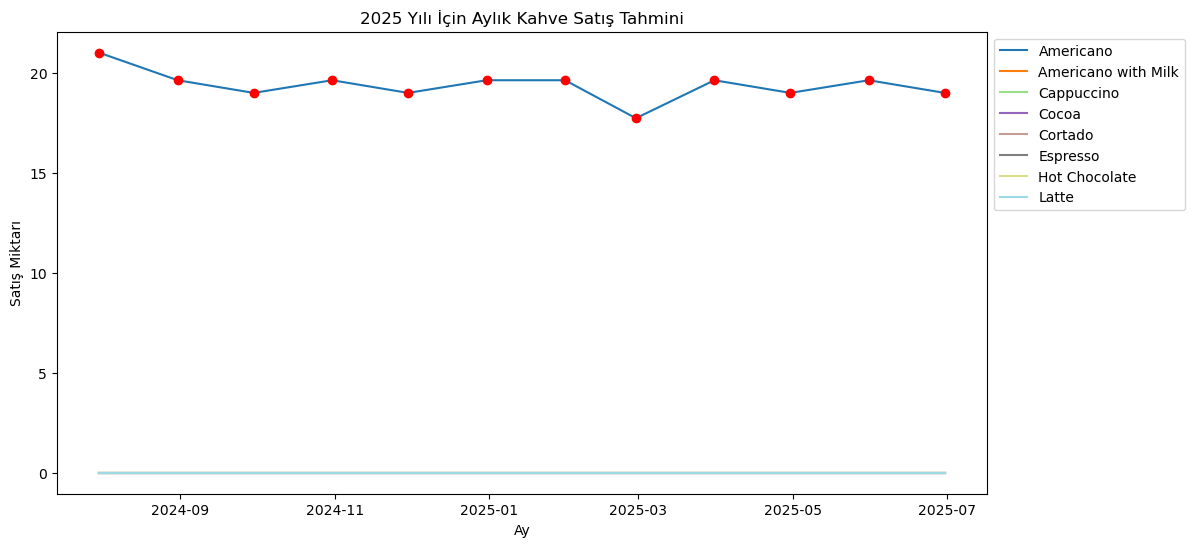

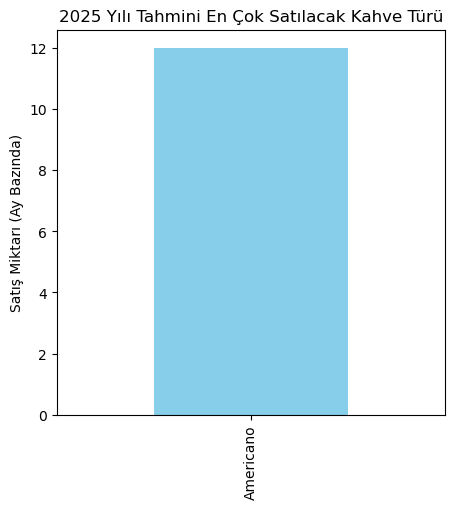

In [325]:
# Gelecek 365 günü tahmin et
future_steps = 365
future_predictions = []

last_data = scaled_data[-time_step:]  # Son zaman adımını al

m.eval()
with torch.no_grad():
    for _ in range(future_steps):
        input_data = torch.tensor(last_data, dtype=torch.float32).unsqueeze(0)
        prediction = m(input_data).numpy()
        future_predictions.append(prediction)
        
        # Yeni tahmin edilen veriyi mevcut verilere ekle
        prediction_reshaped = np.zeros((1, last_data.shape[1]))
        prediction_reshaped[0, :prediction.shape[1]] = prediction
        last_data = np.append(last_data[1:], prediction_reshaped, axis=0)

# Tahminleri ters ölçekleme
future_predictions = np.array(future_predictions).reshape(future_steps, -1)
future_predictions = scaler.inverse_transform(
    np.concatenate((future_predictions, np.zeros((future_steps, scaled_data.shape[1] - future_predictions.shape[1]))), axis=1)
)

# Gelecek tahminlerini zaman serisine ekleme
future_dates = pd.date_range(start=data_all_days.index[-1], periods=future_steps + 1, freq='D')[1:]
future_revenue = pd.DataFrame(future_predictions, index=future_dates, columns=data_all_days.columns)

# Aylık bazda en çok satılan kahve türünü bulma
monthly_future_revenue = future_revenue.resample('ME').sum()
most_sold_coffee_per_month = monthly_future_revenue.idxmax(axis=1)

# Aylık bazda her kahve türü için satış grafiği
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(data_all_days.columns)))
for coffee, color in zip(data_all_days.columns, colors):
    plt.plot(monthly_future_revenue.index, monthly_future_revenue[coffee], label=coffee, color=color)

# En çok satılan kahve türünü ay bazında vurgulama
for idx in monthly_future_revenue.index:
    best_coffee = monthly_future_revenue.loc[idx].idxmax()
    plt.plot(idx, monthly_future_revenue.loc[idx, best_coffee], 'o', color='red')

plt.title('2025 Yılı İçin Aylık Kahve Satış Tahmini')
plt.xlabel('Ay')
plt.ylabel('Satış Miktarı')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# En çok satılan kahve türünü ay bazında gösteren grafik
plt.figure(figsize=(5,5))
most_sold_coffee_per_month.value_counts().plot(kind='bar', color='skyblue')
plt.title('2025 Yılı Tahmini En Çok Satılacak Kahve Türü')
plt.xlabel('')
plt.ylabel('Satış Miktarı (Ay Bazında)')
plt.show()


In [326]:
# Hava durumu verilerini oku
weather_df = pd.read_csv('istanbul_weather.csv', parse_dates=['DateTime'], dayfirst=True)

# Satış verileriyle hava durumu verilerini birleştirme
data_all_days['date'] = data_all_days.index.date
weather_df['date'] = weather_df['DateTime'].dt.date

# Sadece gün ve ay bilgilerini kullanarak birleştirme yapmak için yıl bilgisini çıkar
data_all_days['day_month'] = data_all_days['date'].apply(lambda x: (x.month, x.day))
weather_df['day_month'] = weather_df['date'].apply(lambda x: (x.month, x.day))

# Birleştirilmiş verileri kontrol et
combined_data = pd.merge(data_all_days, weather_df, how='left', on='day_month')
print("Birleştirilen verilerin ilk 5 satırı:")
print(combined_data.head())

Birleştirilen verilerin ilk 5 satırı:
   Americano  Americano with Milk  Cappuccino  Cocoa  Cortado  Espresso  \
0          1                    4           0      1        0         0   
1          3                    3           0      0        0         0   
2          1                    2           0      1        2         0   
3          0                    1           0      0        0         1   
4          0                    0           0      1        1         0   

   Hot Chocolate  Latte      date_x day_month  ... MaxTemp MinTemp   SunRise  \
0              3      2  2024-03-01    (3, 1)  ...      14       9  07:39:00   
1              0      1  2024-03-02    (3, 2)  ...      12       8  07:38:00   
2              2      2  2024-03-03    (3, 3)  ...       9       6  07:36:00   
3              0      2  2024-03-04    (3, 4)  ...      13       6  07:35:00   
4              4      3  2024-03-05    (3, 5)  ...      14       9  07:33:00   

     SunSet  MoonRise   MoonSe

In [327]:
# Boş satırları çıkarma ve sadece ilgili sütunları alma
combined_data = combined_data.dropna(subset=['Condition'])
combined_data = combined_data[['Condition', 'Americano', 'Americano with Milk', 'Cappuccino', 'Latte']]

print("Boş satırlar çıkarıldıktan sonra birleştirilen verilerin ilk 5 satırı:")
print(combined_data.head())

Boş satırlar çıkarıldıktan sonra birleştirilen verilerin ilk 5 satırı:
              Condition  Americano  Americano with Milk  Cappuccino  Latte
0  Patchy rain possible          1                    4           0      2
1            Light rain          3                    3           0      1
2         Partly cloudy          1                    2           0      2
3                 Sunny          0                    1           0      2
4         Partly cloudy          0                    0           0      3


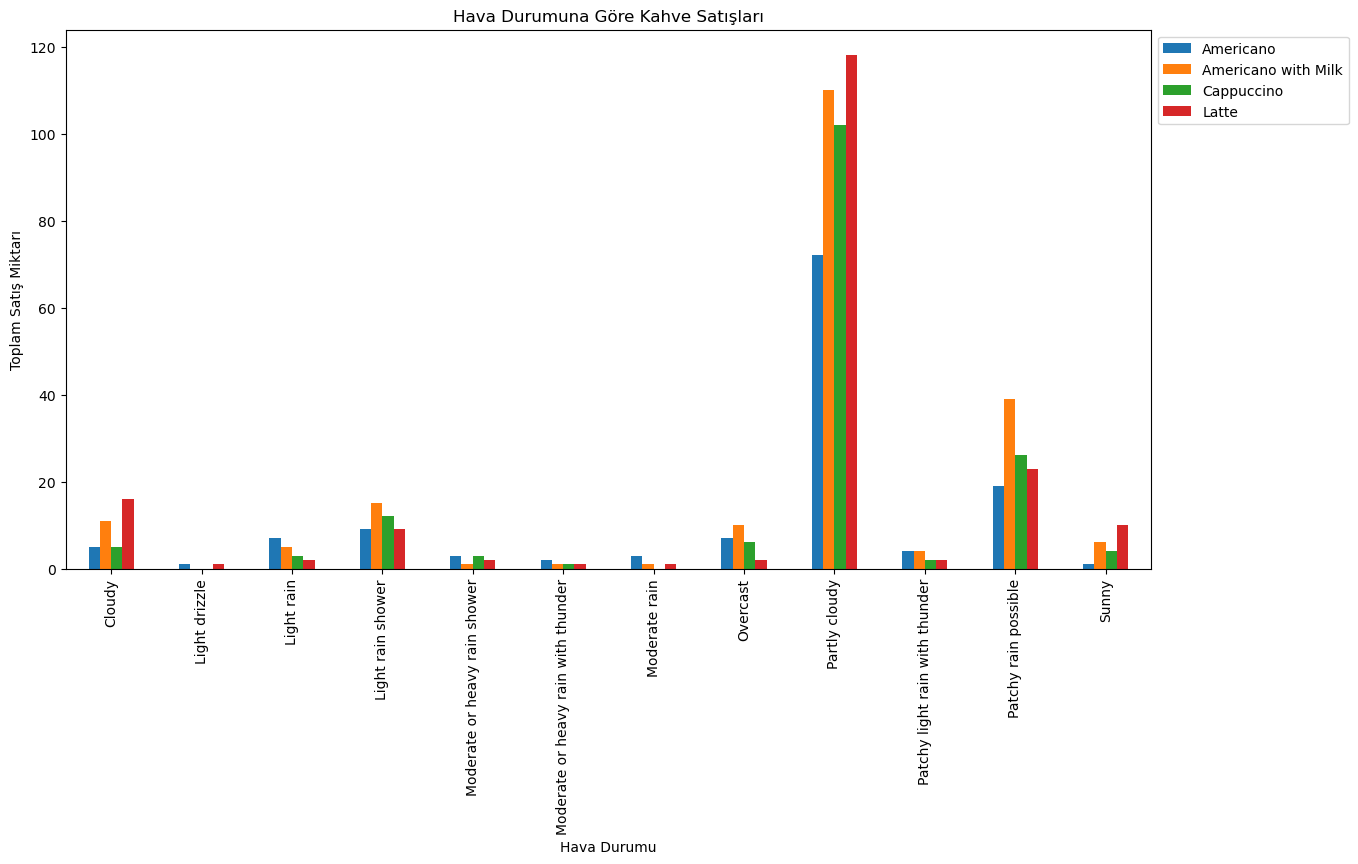

In [328]:
# Hava durumu koşullarına göre satışları analiz etme
weather_conditions = combined_data.groupby('Condition').sum(numeric_only=True)

# Bar grafiği oluşturma
ax = weather_conditions.plot(kind='bar', figsize=(14, 7))
plt.title('Hava Durumuna Göre Kahve Satışları')
plt.xlabel('Hava Durumu')
plt.ylabel('Toplam Satış Miktarı')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [329]:
#Satış verileriyle hava durumu verilerini birleştirme
data_all_days['date'] = data_all_days.index.date
weather_df['date'] = weather_df['DateTime'].dt.date
# Sadece gün ve ay bilgilerini kullanarak birleştirme yapmak için yıl bilgisini çıkar
data_all_days['day_month'] = data_all_days['date'].apply(lambda x: (x.month, x.day))
weather_df['day_month'] = weather_df['date'].apply(lambda x: (x.month, x.day))

# Birleştirilmiş verileri kontrol et
combined_data = pd.merge(data_all_days, weather_df, how='left', on='day_month')
# Boş satırları çıkarma ve sadece ilgili sütunları alma
combined_data = combined_data.dropna(subset=['Condition'])
combined_data = combined_data[['Condition', 'MaxTemp', 'MinTemp', 'Americano', 'Americano with Milk', 'Cappuccino', 'Latte']]

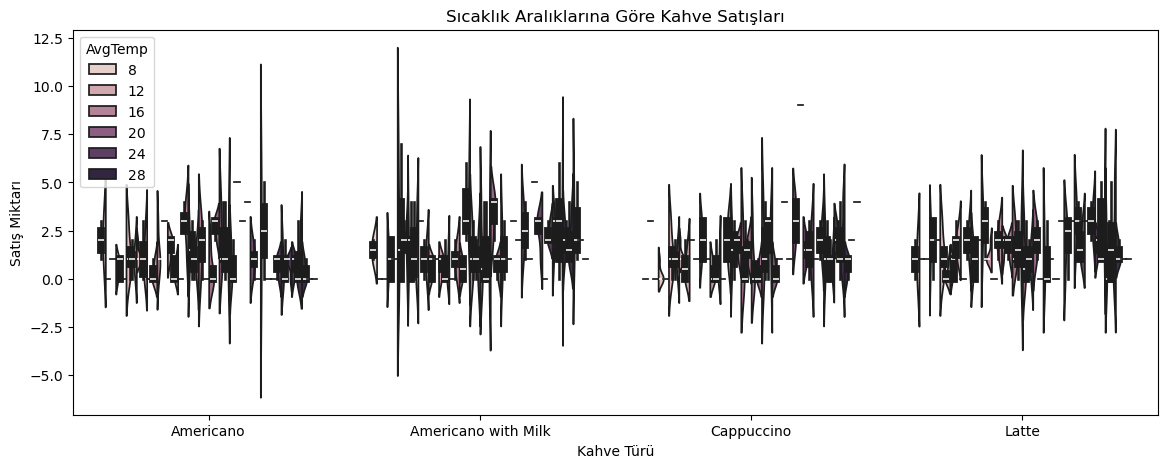

In [330]:
# Günün ortalama sıcaklığını hesaplama
combined_data['AvgTemp'] = (combined_data['MaxTemp'] + combined_data['MinTemp']) / 2
# Sıcaklık aralıklarına göre kahve satışlarını analiz etme
temp_sales = combined_data[['AvgTemp', 'Americano', 'Americano with Milk', 'Cappuccino', 'Latte']]
# Violin (keman) grafiği oluşturma
plt.figure(figsize=(14, 5))
sns.violinplot(data=temp_sales.melt(id_vars='AvgTemp'), x='variable', y='value', hue='AvgTemp', split=True)
plt.title('Sıcaklık Aralıklarına Göre Kahve Satışları')
plt.xlabel('Kahve Türü')
plt.ylabel('Satış Miktarı')
plt.show()